In [16]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [2]:
microglia = sc.read_h5ad("../data/rosmap/microglia.h5ad")


C:\Users\limmi\miniconda3\Lib\site-packages\anndata\compat\__init__.py:371: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [3]:
print(microglia)
sc.pp.highly_variable_genes(microglia, n_top_genes=1000)
adata = microglia[:, microglia.var.highly_variable]
print(microglia)

AnnData object with n_obs × n_vars = 86612 × 4000
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'
AnnData object with n_obs × n_vars = 86612 × 4000
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'


In [37]:
metadata = pd.read_csv("../data/rosmap/rosmap_clinical.csv")
columns = [
        "individualID", "braaksc", "ceradsc", "cogdx"
    ]
metadata = metadata[columns].dropna()
metadata = metadata[metadata["cogdx"] != 6]
metadata["cogdx"] = metadata["cogdx"].astype(int) - 1
metadata["ceradsc"] = metadata["ceradsc"].astype(int) - 1

metadata["braaksc"] = metadata["braaksc"].replace({0: 0, 1: 0, 2: 0, 3: 1, 4: 2, 5: 3, 6: 3})
metadata["ceradsc"] = metadata["ceradsc"].replace({0: 0, 1: 1, 2: 2, 3: 2})
# metadata["cogdx"] = metadata["cogdx"].replace({0: 0, 1: 0, 2: 0, 3: 1, 4: 1})


adata = adata[adata.obs["individualID"].isin(metadata["individualID"])]


In [38]:
braak_dict = dict(zip(metadata["individualID"], metadata["braaksc"]))
cerad_dict = dict(zip(metadata["individualID"], metadata["ceradsc"]))
cogdx_dict = dict(zip(metadata["individualID"], metadata["cogdx"]))
# sc.pp.highly_variable_genes(microglia, n_top_genes=1000)
# adata = microglia[:, microglia.var.highly_variable]

In [39]:
cell_donor_ids = adata.obs["individualID"].values
df = pd.DataFrame(adata.X)
df["donor"] = cell_donor_ids

# Average gene expression per donor
donor_embeddings = df.groupby("donor").mean()

# Merge with labels
donor_embeddings["braak"] = donor_embeddings.index.map(cerad_dict)
print(donor_embeddings)

                 0         1         2         3         4         5  \
donor                                                                  
R1015854 -0.148194 -0.053891 -0.019396 -0.022306 -0.249172 -0.021235   
R1020037 -0.033452 -0.281278 -0.038663 -0.043974 -0.230577 -0.041924   
R1028639 -0.064323 -0.106415 -0.036282 -0.041305  0.111986 -0.003600   
R1042011 -0.396011 -0.114507 -0.030733 -0.035079 -0.018930 -0.033426   
R1042566  0.112389  0.065593  0.043253 -0.052938  2.160887 -0.050494   
...            ...       ...       ...       ...       ...       ...   
R9907075  0.243091 -0.146855 -0.039485 -0.044895 -0.069217 -0.042805   
R9936070  0.199899 -0.290691 -0.044995 -0.051061 -0.182295  0.118182   
R9938583 -0.327500  0.071154 -0.042763  0.282914 -0.364183  0.169091   
R9976232  0.138099  0.207032  0.018003 -0.010360  0.707276  0.009777   
R9996478 -0.012424  0.070454 -0.044299  0.021419 -0.166895 -0.047954   

                 6         7         8         9  ...       991

In [41]:
X = donor_embeddings.drop(columns=["braak"])
y = donor_embeddings["braak"]
print("Distribution of classes:")
print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = xgb.XGBClassifier(
    n_estimators=100,      # number of trees
    max_depth=6,           # depth of trees
    learning_rate=0.1,     # step size shrinkage
    n_jobs=-1,             # use all CPU cores
    tree_method='hist',    # fast histogram-based training
    use_label_encoder=False,
    eval_metric='mlogloss' # good for multi-class
)

# model.fit(X_train, y_train)
svm_model = SVC(kernel='linear', C=1.0, gamma='scale', probability=True)  # You can try 'linear' or 'poly' kernels too

# Train the model
svm_model.fit(X_train, y_train)


# Evaluate
y_pred = svm_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Report:\n", classification_report(y_test, y_pred))

Distribution of classes:
braak
2    151
1    151
0    132
Name: count, dtype: int64
Accuracy: 0.4482758620689655
Report:
               precision    recall  f1-score   support

           0       0.47      0.56      0.51        27
           1       0.31      0.27      0.29        30
           2       0.55      0.53      0.54        30

    accuracy                           0.45        87
   macro avg       0.44      0.45      0.45        87
weighted avg       0.44      0.45      0.44        87



In [17]:
donors = microglia.obs["individualID"]
braakscores = donors.map(braak_dict)
ceradscores = donors.map(cerad_dict)
cogdxscores = donors.map(cogdx_dict)


expr = pd.DataFrame(microglia.X, index=microglia.obs_names, columns=microglia.var_names)
expr['donor'] = donors.values
expr['braaksc'] = braakscores.values
expr['ceradsc'] = ceradscores.values
expr['cogdx'] = cogdxscores.values

avg_expr = expr.groupby('donor').mean()

temp1 = avg_expr['braaksc']
temp2 = avg_expr['ceradsc']
temp3 = avg_expr['cogdx']

avg_expr = avg_expr.drop(columns=['braaksc', 'ceradsc', 'cogdx'])

from anndata import AnnData
donor_adata = AnnData(avg_expr)
donor_adata.obs['braaksc'] = temp1.values
donor_adata.obs['ceradsc'] = temp2.values
donor_adata.obs['cogdx'] = temp3.values
print(donor_adata)


AnnData object with n_obs × n_vars = 450 × 4000
    obs: 'braaksc', 'ceradsc', 'cogdx'


In [7]:
adata.obs["braaksc"] = adata.obs["individualID"].map(braak_dict)
adata.obs["ceradsc"] = adata.obs["individualID"].map(cerad_dict)
adata.obs["cogdx"] = adata.obs["individualID"].map(cogdx_dict)


print(donor_adata)
                                                     

C:\Users\limmi\AppData\Local\Temp\ipykernel_13296\2627734331.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["braaksc"] = adata.obs["individualID"].map(braak_dict)


AnnData object with n_obs × n_vars = 434 × 4000
    obs: 'braaksc', 'ceradsc', 'cogdx'


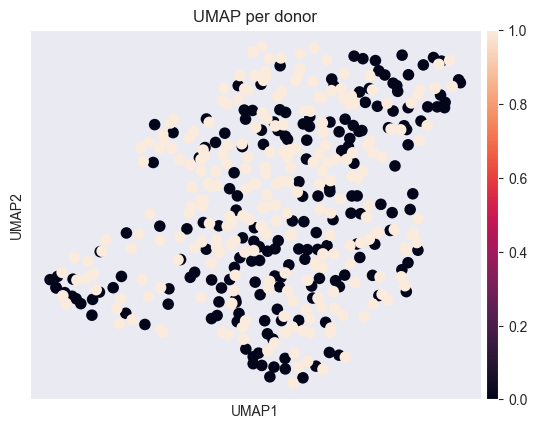

In [8]:
sc.pp.scale(donor_adata)
sc.tl.pca(donor_adata)
sc.pp.neighbors(donor_adata)
sc.tl.umap(donor_adata)
sc.pl.umap(donor_adata, color='braaksc', title='UMAP per donor')

In [9]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)


In [10]:
sc.tl.leiden(adata, resolution=1.0)


C:\Users\limmi\AppData\Local\Temp\ipykernel_13296\3085483194.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1.0)


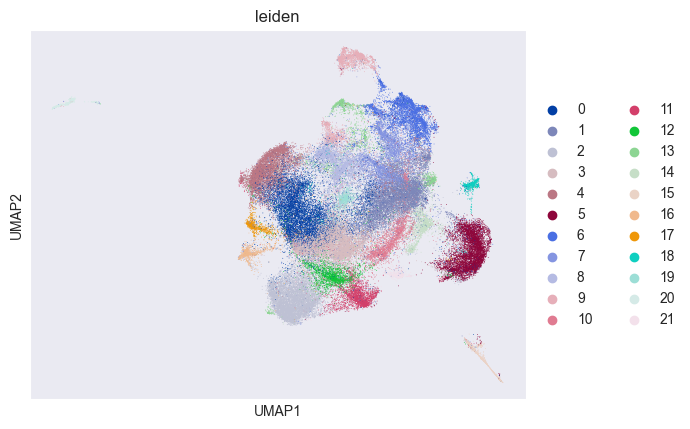

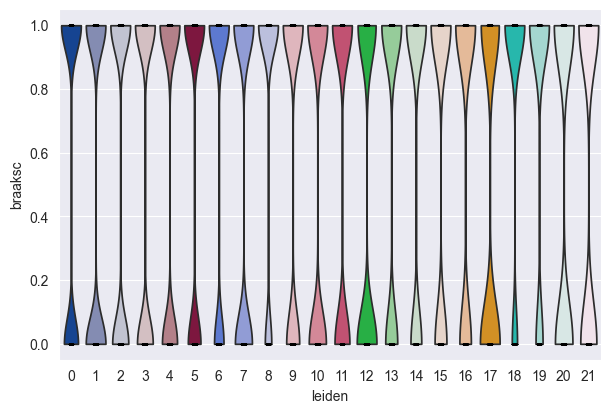

In [13]:
sc.pl.umap(adata, color='leiden')
sc.pl.violin(adata, keys='braaksc', groupby='leiden')